In [159]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import cv2
import time
import numpy as np
import tensorflow as tf
import skimage.transform
from src.model import Model as Attn_Model
from src.baseline_classify import Model as Clfy_Model
from src.data_loader_pred_classify import dataLoader
import matplotlib.pyplot as plt

In [2]:
import matplotlib.patches as patches

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
# Change if needed
n_iters     = 1
print_every = 100
batch_size  = 44
img_size    = (16,16)
max_steps   = 7
width       = img_size[0]
height      = img_size[1]
pretrained_clfy_model = './model/clsfy1/model-640'
pretrained_attn_model = './model/lstm1/model-1000'

### Functions

In [58]:
def valid_pred_bboxs(pred_bboxes):
    def box_threshold(left, top, width, height):
        valid_box = False
        # If the threshold box is less than 10
        if width * height < 10:
            valid_box = False
        elif int(left) == 0 and int(top) == 0 and\
             int(width) == 0 and int(height) == 0:
            valid_box = False
        else:
            valid_box = True

        return valid_box
    
    valid_pred_bboxs = []
    for t in range(batch_size):
        interm_pred_bboxs = []
        for T in range(max_steps):
            # Ignore first and last prediction
            if T != 0 and T+1 != max_steps:
                # Predicted bounding box
                smple_left   = abs(pred_bboxes[T][t][0])
                smple_top    = abs(pred_bboxes[T][t][1])
                smple_width  = abs(pred_bboxes[T][t][2])
                smple_height = abs(pred_bboxes[T][t][3])
                # Check if the box is valid
                vld_bbx_pred = box_threshold(left=smple_left, top=smple_top,\
                                     width=smple_width, height=smple_height)
                # Collect if valid box
                if vld_bbx_pred:
                    interm_pred_bboxs.append([smple_left, smple_top, smple_width, smple_height])
        # Collect
        valid_pred_bboxs.append(interm_pred_bboxs)
    
    return valid_pred_bboxs

In [62]:
def crop_and_resize(images, bboxes):
    images_crop_resize = []
    for t in range(len(bboxes)):
        image = images[t] # Sample image
        bbox  = bboxes[t] # Sample predictions
        interm_images_crop_resize = []
        # Loop through predictions
        for bbx in bbox:
            sample_left   = abs(int(bbx[0]))
            sample_top    = abs(int(bbx[1]))
            sample_width  = abs(int(bbx[2]))
            sample_height = abs(int(bbx[3]))

            image_patch = image[sample_top:sample_top+sample_height, sample_left:sample_left+sample_width, :]
            # Zooming
            image_patch_rz = cv2.resize(image_patch, (width, height), interpolation = cv2.INTER_AREA)
            # Normalize image between -1 and 1
            image_patch_rz = image_patch_rz /127.5 - 1.0
            # Collect
            interm_images_crop_resize.append(image_patch_rz)
        # Append to main
        images_crop_resize.append(interm_images_crop_resize)

    return images_crop_resize

### Main

In [7]:
# Load train dataset
data = dataLoader(directory='./dataset', dataset_dir='test_cropped',\
                  dataset_name='test.txt', max_steps=7, mode='Test')

All data-loaded!


#### BBox prediction

In [207]:
tf.reset_default_graph()

In [208]:
# Load Attention Model
attn_model = Attn_Model(dim_feature=[49, 128], dim_hidden=128, n_time_step=7,
                        alpha_c=1.0, image_height=64, image_width=64, mode='test')

In [209]:
# Test loader
test_loader = data.gen_data_batch(batch_size)

In [210]:
# Build model
pred_bboxs_, _  = attn_model.build_test_model()


CNN build model sucess!


In [211]:
# Set GPU options
config = tf.GPUOptions(allow_growth=True)

In [215]:
## Run FeedForward

# Collect predictions from runs for viz
vis_images  = []
pred_bboxes = []

# Test Data Loader
test_gen = data.gen_data_batch(batch_size)

# Set GPU options
config = tf.GPUOptions(allow_growth=True)

with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    if pretrained_attn_model is not None:
        print("Start testing with pretrained Attention Model..")
        saver.restore(sess, pretrained_attn_model)
    else:
        print("Start testing with Attention Model with random weights...")

    for i in range(n_iters):
        image_batch, image_norm_batch, label_batch = next(test_gen)
        feed_dict = {attn_model.images: image_norm_batch,
                     attn_model.drop_prob: 1.0}
        prediction_bboxes = sess.run(pred_bboxs_, feed_dict)
        
        pred_bboxes.append(prediction_bboxes)
        
        if i%print_every == 0:
            print('Inference Completion..{%d/%d}' % (i, n_iters))
    #-----------------------------------------------------
    print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
    print('Completed!')
# Close session
sess.close()

Start testing with pretrained Attention Model..
INFO:tensorflow:Restoring parameters from ./model/lstm1/model-1000
Inference Completion..{0/1}
Inference Completion..{1/1}
Completed!


In [216]:
# Get Valid 
for i in range(len(pred_bboxes)):
    vald_prdct_bbxs = valid_pred_bboxs(pred_bboxes=pred_bboxes[i])
    images_crop_rez = crop_and_resize(images=image_batch, bboxes=vald_prdct_bbxs)
    images_crop_rez = np.array(images_crop_rez)

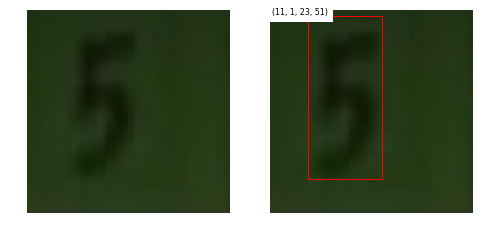

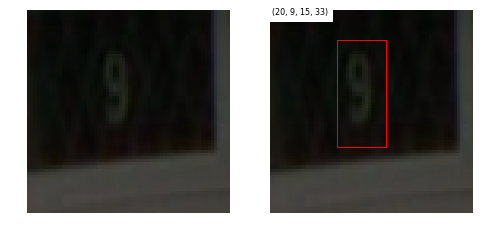

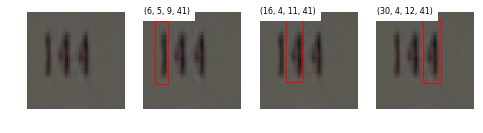

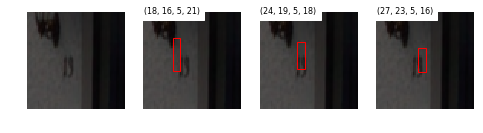

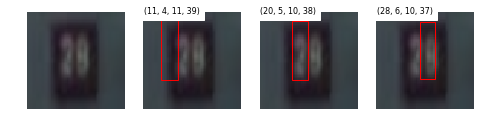

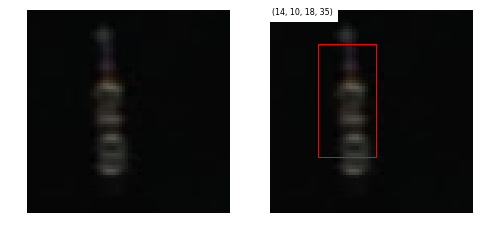

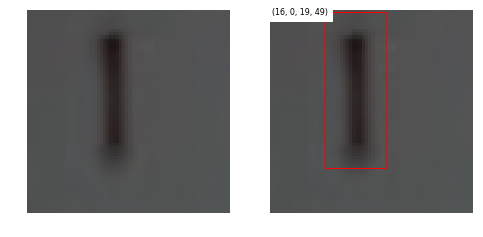

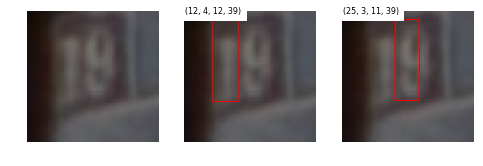

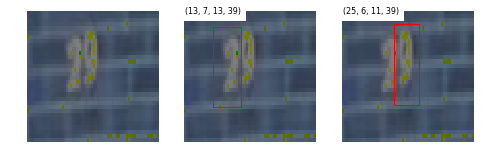

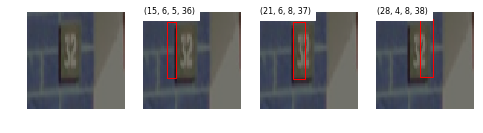

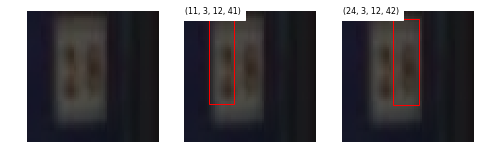

In [217]:
for t in range(0, len(image_batch), 4):
    # Plot original image
    fig,ax = plt.subplots(1, len(vald_prdct_bbxs[t])+1)
    ax[0].imshow((image_batch[t] + 1)*127.5)
    ax[0].axis('off')
    for T in range(len(vald_prdct_bbxs[t])):
        ax[T+1].imshow((image_batch[t] + 1)*127.5)
        sample_left  = vald_prdct_bbxs[t][T][0]
        sample_top   = vald_prdct_bbxs[t][T][1]
        sample_width = vald_prdct_bbxs[t][T][2]
        sample_heigt = vald_prdct_bbxs[t][T][3]

        rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  
        ax[T+1].text(0, 1, (int(sample_left), int(sample_top), int(sample_width), int(sample_heigt)), color='black', backgroundcolor='white', fontsize=8)
        ax[T+1].add_patch(rect1)
        ax[T+1].axis('off')
    
    plt.show()

#### Digit  Classification

In [218]:
tf.reset_default_graph()

In [219]:
# Load Classification Model
clfy_model = Clfy_Model(image_height=16, image_width=16, mode='test')

In [220]:
_, predictions  = clfy_model.build_test_model()

Classification build model sucess!


In [221]:
saver = tf.train.Saver()

In [222]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    all_predictions = []
    if pretrained_clfy_model is not None:
        print("Start testing with Classification pretrained Model..")
        saver.restore(sess, pretrained_clfy_model)
    else:
        print("Start testing with Classification Model with random weights...")
    
    for i in range(len(images_crop_rez)):
        pred_len = len(images_crop_rez[i])
        interm_predictions = []
        try :
            input_seq = np.array(images_crop_rez[i])
            feed_dict = {clfy_model.images: input_seq,
                         clfy_model.drop_prob: 1.0}
            pred = sess.run(predictions, feed_dict)
            interm_predictions.append(pred)
        except IndexError:
            interm_predictions.append(None)
        # Collect all outputs
        all_predictions.append(interm_predictions)
# Close session
sess.close()

Start testing with Classification pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/clsfy1/model-640


In [223]:
len(all_predictions)

44

In [224]:
len(label_batch)

44

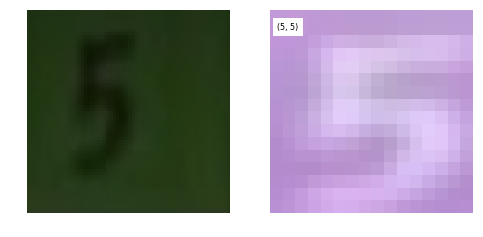

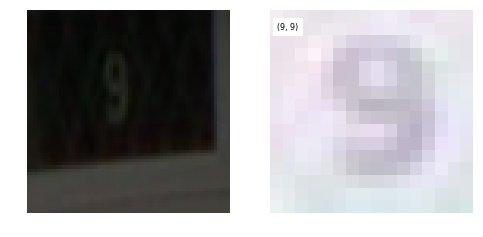

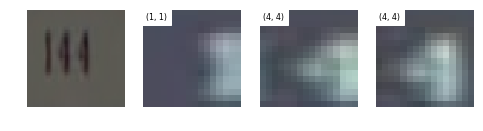

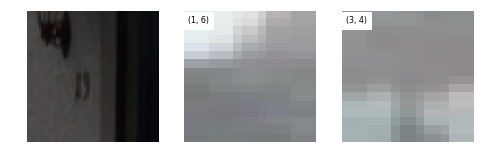

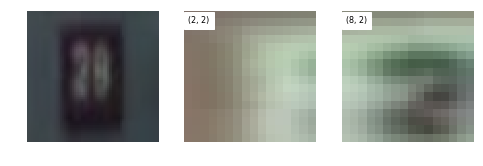

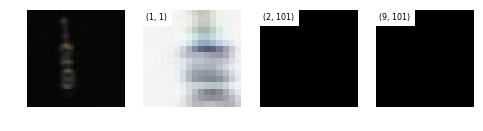

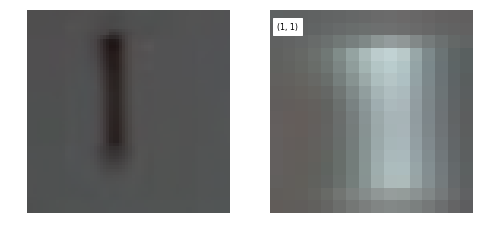

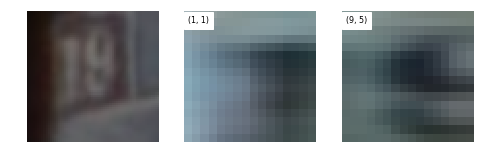

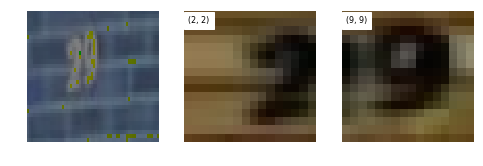

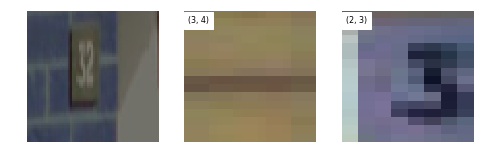

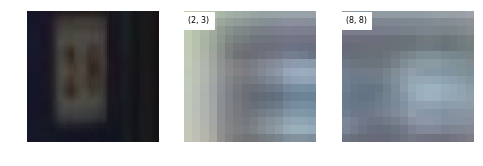

In [227]:
for t in range(0, len(image_batch), 4):
    # Plot original image
    fig,ax = plt.subplots(1, len(label_batch[t])+1)
    ax[0].imshow((image_batch[t] + 1)*127.5)
    ax[0].axis('off')
    for T in range(len(label_batch[t])):
        try :
            ax[T+1].imshow((images_crop_rez[t][T] + 1)*127.5)
        except IndexError:
            ax[T+1].imshow(zeros)
        # Title
        try :
            ax[T+1].text(0, 1, (np.argmax(label_batch[t][T]), all_predictions[t][0][T]), color='black', backgroundcolor='white', fontsize=8)
        except IndexError:
            ax[T+1].text(0, 1, (np.argmax(label_batch[t][T]), 101), color='black', backgroundcolor='white', fontsize=8)
            
        ax[T+1].axis('off')
    
    plt.show()